Marcin Wardyński  
czwartek, 8:00

Pytania do ćwiczenia dość dobrze pokrywają moje spostrzeżenia podczas wykonywania ćwiczenia, więc ograniczę do minimum komentarz kodu, a swoje przemyślenia zawrę odpowiadając na pytania.

W ramach przygotowania do ćwiczenia wybieram tysiąc zapytań z korpusu FIQA-PL, oraz ładuję wytrenowany już pipeline do przetwarzania w `SpaCy` dla języka polskiego: `pl_core_news_sm`. Nie wszystkie elementy z tego pipeline-u wykorzystuję, lecz wygodniej jest mi skorzystać z pełnego przetwarzania, później wybierać interesujące mnie elementy, typu podział na zdania, czy też lematyzację tokenów.

In [52]:
from datasets import load_dataset
seed = 7
passage_number = 1000

corpus = load_dataset("clarin-knext/fiqa-pl", name="corpus")
passages = corpus['corpus'].shuffle(seed=seed).select(range(passage_number))['text']


In [ ]:
!python -m spacy download pl_core_news_sm

Poza eliminacją pierwszych słow w zdaniu wykluczam również pierwsze słowo w cytacie, oraz pierwsze słowo za znakiem `>` - więcej na ten temat w odpowiedzi do pytania drugiego.

Lematyzacja nie wydaje się być konsystenta co do wielkości liter. "Twój" jest zamienianie na "twój", natomiast "Twoich" na "Twój", czyli z jakiegoś powodu wielka litera została pozostawiona, dlatego też stosuję funkcję `lower()` do wszystkich odnalezionych lematów.

In [96]:
import pl_core_news_sm
from collections import Counter

nlp = pl_core_news_sm.load()
skip_first_token_after_spec_char = True
spec_chars = set(["„", "\"", ">"])

def find_capital_nouns_naive(passages):
    title_token_counter = Counter()
    for passage in passages:
        doc = nlp(passage)
        for sentence in doc.sents:
            skip_next_token = True
            for token in sentence:
                if skip_first_token_after_spec_char and token.text in spec_chars:
                    skip_next_token = True
                    continue
                elif not skip_next_token and token.is_title:
                    title_token_counter[token.lemma_.lower()] += 1
                skip_next_token = False
    return title_token_counter
            
title_tokens = find_capital_nouns_naive(passages)
title_tokens.most_common(50)

[('twój', 210),
 ('ty', 139),
 ('ciebie', 53),
 ('stany', 44),
 ('zjednoczone', 42),
 ('trump', 38),
 ('roth', 32),
 ('hamilton', 31),
 ('amazon', 30),
 ('douglas', 29),
 ('wielki', 25),
 ('indie', 24),
 ('brytania', 22),
 ('a', 21),
 ('uber', 21),
 ('twojego', 20),
 ('x', 20),
 ('bank', 19),
 ('w', 19),
 ('google', 17),
 ('chiny', 16),
 ('kanada', 16),
 ('apple', 15),
 ('b', 15),
 ('nowy', 15),
 ('fed', 15),
 ('target', 15),
 ('internet', 14),
 ('być', 14),
 ('s&p', 13),
 ('jeśli', 13),
 ('słowo', 13),
 ('the', 12),
 ('e', 12),
 ('p', 12),
 ('vanguard', 11),
 ('china', 11),
 ('najlepsze', 11),
 ('twoją', 11),
 ('f', 11),
 ('czy', 10),
 ('jork', 10),
 ('donald', 10),
 ('móc', 9),
 ('europa', 9),
 ('trumpa', 9),
 ('podsumowanie', 9),
 ('nie', 9),
 ('wall', 9),
 ('street', 9)]

Widzimy powyżej, że na szczycie listy TOP50 najczęściej spotykanych nazw własnych znajdują się zaimki osobowe i dzierżawcze, których wcale tu nie powinno być.


W dalszej części ćwiczenia zmienię podejście i zamiast rozpoznawać nazwy własne po wielkości pierwszej litery skorzystam z NER pakiety SpaCy.  
Dodatkowo przeprowadzam lematyzację dostarczonych nazw, żeby w bardziej dokładny sposób zliczyć wystąpienia poszczególnych nazw własnych.

In [83]:
def find_names_entities(passages):
    classes_counter = Counter()
    class_to_ner_counter = {}
    ner_counter = Counter()
    diff_classes_sents = []

    for passage in passages:
        doc = nlp(passage)
        this_sent_classes = set()
        for ent in doc.ents:
            ent_lemmas = " ".join([token.lemma_.lower() for token in ent])
            
            classes_counter[ent.label_] += 1
            
            if ent.label_ not in class_to_ner_counter.keys():
                class_to_ner_counter[ent.label_] = Counter()
            class_to_ner_counter[ent.label_][ent_lemmas] += 1
            
            ner_counter[f"{ent_lemmas} - {ent.label_}"] += 1
            
            this_sent_classes.add(ent.label_)
        if len(this_sent_classes) >= 2:
            diff_classes_sents.append((passage, doc.ents))

    return classes_counter, class_to_ner_counter, ner_counter, diff_classes_sents

classes_counter, class_to_ner_counter, ner_counter, diff_classes_sents = find_names_entities(passages)

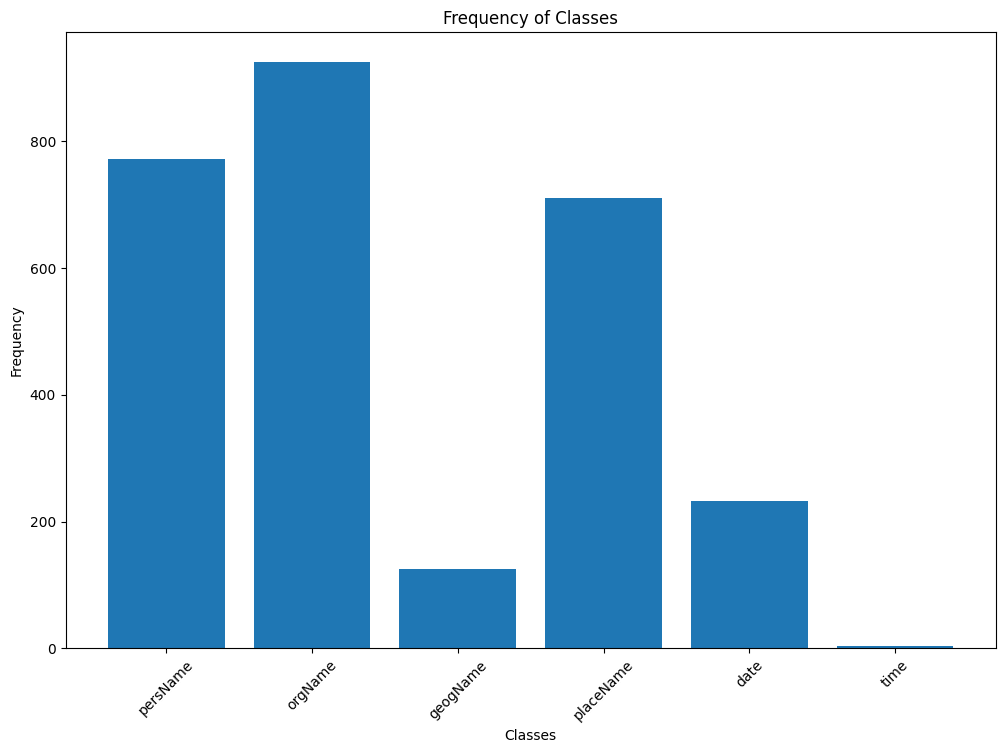

In [95]:
import matplotlib.pyplot as plt

classes = list(classes_counter.keys())
frequency = list(classes_counter.values())

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.bar(classes, frequency)
plt.title("Frequency of Classes")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

Patrząc na klasy odnajdowanych nazw własnych, najczęściej mamy do czynienia z nazwami organizacji, następnie nazwami osób i miejsc, daty i nazwy geograficzne znacznie ustępują pierwszej trójce, natomiast najrzadziej występuje określenie czasu, gdyż tylko trzy razy w całym tysiącu wybranych pasaży. 

In [92]:
N=10

for ner_class in class_to_ner_counter.keys():
    print(f"Class: {ner_class}:")
    print(class_to_ner_counter[ner_class].most_common(N))

Class: persName:
[('amazon', 26), ('trump', 23), ('hamilton', 19), ('douglas', 17), ('sald', 12), ('gdyby być', 11), ('fed', 11), ('gdybyś', 10), ('uber', 10), ('vanguard', 9)]
Class: orgName:
[('ira', 44), ('ipo', 25), ('etf', 22), ('irs', 22), ('google', 18), ('apple', 17), ('roth', 15), ('target', 14), ('mba', 12), ('cc', 11)]
Class: geogName:
[('europa', 7), ('europejski', 5), ('guam', 4), ('boeing', 4), ('wall street', 3), ('betterment', 3), ('azjatycki', 3), ('uber', 3), ('nasdaq', 3), ('ameryka', 3)]
Class: placeName:
[('usa', 127), ('amerykański', 61), ('stany zjednoczone', 33), ('indie', 24), ('wielki brytania', 22), ('kanada', 16), ('chiny', 15), ('nowy jork', 10), ('maklerski', 9), ('niemcy', 8)]
Class: date:
[('1099', 11), ('2008 rok .', 4), ('2008', 4), ('2011 rok .', 4), ('sierpień', 3), ('2013', 3), ('20111230', 3), ('2012', 3), ('xx wiek', 3), ('grudzień', 2)]
Class: time:
[('16:00 po południe', 1), ('5 w noc', 1), ('12:56 .', 1)]


Powyżej TOP10 dla każdej odnalezionej klasy nazw własnych. Wnioski co do jakości odnalezionych wyrazów znajdują się w odpowiedzi na pytanie czwarte.

In [93]:
N=50

ner_counter.most_common(N)

[('usa - placeName', 127),
 ('amerykański - placeName', 61),
 ('ira - orgName', 44),
 ('stany zjednoczone - placeName', 33),
 ('amazon - persName', 26),
 ('ipo - orgName', 25),
 ('indie - placeName', 24),
 ('trump - persName', 23),
 ('etf - orgName', 22),
 ('irs - orgName', 22),
 ('wielki brytania - placeName', 22),
 ('hamilton - persName', 19),
 ('google - orgName', 18),
 ('apple - orgName', 17),
 ('douglas - persName', 17),
 ('kanada - placeName', 16),
 ('chiny - placeName', 15),
 ('roth - orgName', 15),
 ('target - orgName', 14),
 ('mba - orgName', 12),
 ('sald - persName', 12),
 ('gdyby być - persName', 11),
 ('cc - orgName', 11),
 ('1099 - date', 11),
 ('roth ira - orgName', 11),
 ('fed - persName', 11),
 ('gdybyś - persName', 10),
 ('nowy jork - placeName', 10),
 ('uber - persName', 10),
 ('vanguard - persName', 9),
 ('hsa - orgName', 9),
 ('maklerski - placeName', 9),
 ('hoa - orgName', 9),
 ('niemcy - placeName', 8),
 ('joe - persName', 8),
 ('japonia - placeName', 7),
 ('cpa -

Lista najczęstszych nazw własnych zwrócona przez NER również zawiera kilka chochlików, jak np.: "gdyby być" jako nazwa osoby.

Lematyzacja wprowadza również pewne błędy do odnalezionych nazw własnych, np.: "wielki brytania", jednak zyski z jej wprowadzenia przewyższają te małe niedogodności z błędną odmianą gramatyczną.

In [94]:
from spacy import displacy

N = 5

for sent, ents in diff_classes_sents[:N]:
    highlighted_entities = [{"start": ent.start_char, "end": ent.end_char, "label": ent.label_} for ent in ents]

    displacy.render(
    {"text": sent, "ents": highlighted_entities, "title": "Named Entities"},
    style="ent",
    manual=True,
    options={"colors": {"persName": "lightblue", "orgname": "lightgreen", "geogName": "orange", "placeName": "salmon", "date": "magenta", "time": "cyan"}},
)



W nazwach własnych zakreślonych powyżej można doszukać się pewnych nieścisłości i błędów, które też komentuję głównie odpowiadając na pytanie trzecie.

#### 1. Która metoda sprawdza się lepiej do rozpoznawania nazw własnych?
Zdecydowanie NER daje lepsze wyniki. Słowa zaczynające się od wielkiej litery wprowadzają wiele nieprawidłowych wyników, o których piszę punkt niżej. NER mniejszym nakładem pracy daje dokładniejsze wyniki, lecz również nie jest pozbawiony wad. Dużo tu zależy od jakości narzędzia w danym języku, które zotało użyte do przeprowadzenia NER.

#### 2. Jakie są wady metody opierającej się na wielkich literach?
- pomija pierwsze wyrazy w zdaniu, więc jeśli będzie to nazwa własna, to nie zostanie uwzględniona
- zawiera dużo wyników, które nie są nazwami własnymi, jak w naszym przypadku zaimki osobowe i dzierżawcze pisane z wielkiej litery ze względów grzecznościowych, które to okupują topowe miejsca listy częstotliwości występowania
- wielka litera bywa nadużywana, przez co algorytm rozpoznaje niewłaściwe słowa, jako nazwy własne, np.:
    - "... czeki na niektóre Rachunki inwestycyjne"
    - "... Konto oszczędnościowe..."
- traktuje każdy wyraz osobno, np.: "Stany", "Zjednoczone".
- wymaga własnego podejścia w kwestii odrzucania wyrazów rozpoczynających nową strukturę zdaniową, nie tylko początek zdania, ale również:
    - cytowania za cudzysłowem
    - frazy w nawiasie
    - wyliczania za dwukropkiem
    - itp.  
We wszystkich powyższych konstrukcjach autor analizowanego pasażu może pokusić się o napisanie pierwszego wyrazu z wielkiej litery. W naszym ćwiczeniu zdecydowałem się jedynie na eliminowaniu ze zliczania pierwszych wyrazów w cudzysłowiu, lub za znakiem `>`, gdyż uważam że takie podejście nie wyeliminuje zbyt wielu wyrazów, które rozpoczynają zdanie w nawiasach, bądź też wyliczenia, a jednocześnie odfiltruje pierwsze wyrazy odpowiedzi, które są de facto pierwszym wyrazem zdania, a sama odpowiedź zawarta jest w cudzysłowach, lub też za znakiem `>`.

#### 3. Jakie są wady metody NER?
- Niekoniecznie dobrze wybiera, czy też klasyfikuje nazwy własne. Kilka przykładów z pięciu zdań z ostatniego ćwieczenia:
    - azcoastal -> nie zakwalifikowany, bo napisany z małej litery w zdaniu 1.
    - The Creature From Jekyll Island -> tytuł książki uznany za nazwę organizacji
    - Round -> nazwa osoby w zdaniu 2.
    - Rachunki -> nazwa geograficzna w zdaniu 3.
    - Vanguard -> raz nazwą osoby, a raz miejsca w zdaniu 4.
    - Brazylia -> raz nazwa miejsca, a raz osoby w zdaniu 5.  
    To są tylko niektóre z popełnionych błędów, które przyjmują różny charakter:
    - nie rozpoznawanie nazw własnych
    - ogranicona liczba klas dla nazw własnych, co skutkuje ich niewłaściwą klasyfikacją
    - brak konstystencji w nazywaniu klas
- Również listing najpopularniejszych nazw własnych w każdej kategorii dostarcza ciekawych kontraprzykładów:
    - amazon, a co gorsza "gdyby być" oraz "gdybyś" jako nazwy osoby
    - boeing nazwą geograficzną
    - uber zarówno nazwą osoby oraz geograficzną
    - itd.
- Jest tylko tak dobry, jak reguły rozpoznawania i klasyfikowania nazw własnych, które w nim zaszyli autorzy

#### 4. Która z grup w klasyfikacji dostarczonej przez NER ma najlepsze, a która ma najgorsze rezultaty?

Swój osąd będę bazowała na listingu dziesięciu najpopularniejszyc naw własnych dla każdej z grup.

W zasadzie każda grupa zawiera zawiera wśród TOP10 jakieś osobniki, które nie powinny się w niej znaleźć.

Najlepiej zdaje się wypadać grupa z nazwami miejsc, która to zawiera nazwy krajów, kontynentów, czy też miast. Jedyną gafą w TOP10 jest słowo "maklerski", które w zasadzie nawet nie powinno zostać zakwalifikowane jako nazwa własna.

Najgorzej oceniłbym klasę z nazwami osób, której małym przewinienie jest zawieranie nazw niektórych organizacji, jak "Amazon", czy "FED". Największym problemem tej klasy jest wysokie miejsce zwrotów "gdyby być" oraz "gdybyś", które pod żadnym pozorem nie są nazwami własnymi. Generalnie nazwy osób tej kategorii nie stanowią nawet połowy TOP10.

#### 5. Czy NER wystarcza do rozpoznania tej samej jednostki pod różnymi nazwami? Jeśli nie, to zasugeruj algorytm, który temu zadaniu podoła.

Niestety NER nie nadaje się do rozpoznania tej samej jednostki pod różnymi nazwami.

Można pomyśleć o wielu potencjalnych rozwiązaniach i każde przychodzi ze swoimi wadami i zaletami. Oto kilka z nich:

- Ręcznie utworzony słownik synonimów dla nazw własnych opisujących tą samą jednostkę
- Model językowy bazujący na Word2Vec lub transformerze do rozpoznawania synonimów

Z powyższych elementów można stworzyć następujący algorytm:
1. NER wyszukuje nazw własnych
2. Nazwy własne ulegają lematyzacji
3. Porównujemy nazwy własne z wpisami w słowniku synonimów nazw własnych i na jego podstawie grupujemy
4. Nazwy własne niedopasowane na poziomie słownika, staramy się dopasować i pogrupować modelem językowym
5. Tworzymy grupy jedno-elementowe dla nazw własnych nie będących jeszcze w grupach.
6. Ostatecznie nazwy własne umieszczone w jednej grupie odpowiadają jednej jednostce.

Algorytm ten nie jest idealny, lecz przy bogatym słowniku synonimów i (lub) dobrze wytrenowanym modelu językowym, powinien dostarczać całkiem dobre grupy nazw własnych dla tych samych jednostek.

#### 6. Jakie faktyczne problemy mogą zostać rozwiązane przez NER?

NER może posłużyć bardzo dobrze do ekstrakcji nazw własnych/dat z dokumentów. Jest to zabieg bardzo przydatny w obecnej dobie wykładniczego przyrostu publikowanych treści. Niezależnie od rodzaju dokumentu:
- artykuł na wiki
- akt prawny
- notka zawiadamiająca
- itp.

Nazwy własne bardzo pomagają w ich przeszukiwaniu. Można skoncentrować się na ważnych informacjach, typu:
- kogo/czego dotyczy
- od kiedy (horyzont czasowy)
- autor
Dzięki czemu w prostszy i bardziej precyzyjny sposób możemy odszukać treści/przepisy, które nas dotyczą.